# OCR 살펴보기

## Concept

OCR(Optical Character Recognition) = Text detection + Text recognition

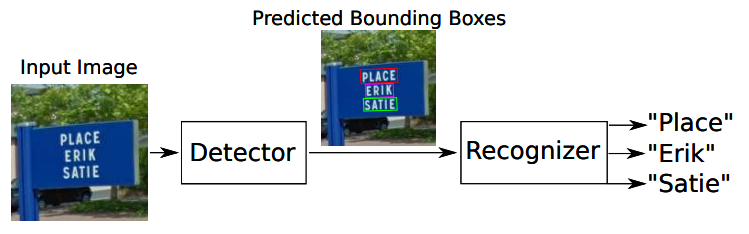

> * 물체(Text)를 검출하는 Text detection
> * 검출된 문자를 인식하는 Text recognition

## Tesseract OCR (딥러닝 기반 X)

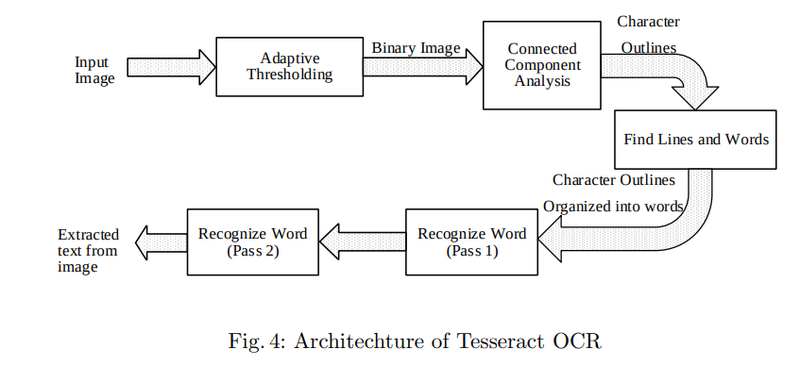

* Adaptive Thresholding 단계에서 컬러이미지를 흑백이미지로 변환
* Connected Component Analysis 단계에서 문자 영역 검출
* Find Lines and Words 단계에서 라인, 단어를 추출
* Recognize Word 단계에서 단어이미지를 Text로 변환하기 위해 문자를 하나씩 인식하고 재결합

## Text detection(EAST)

[논문 : EAST: An Efficient and Accurate Scene Text Detector](https://arxiv.org/pdf/1704.03155v2.pdf)

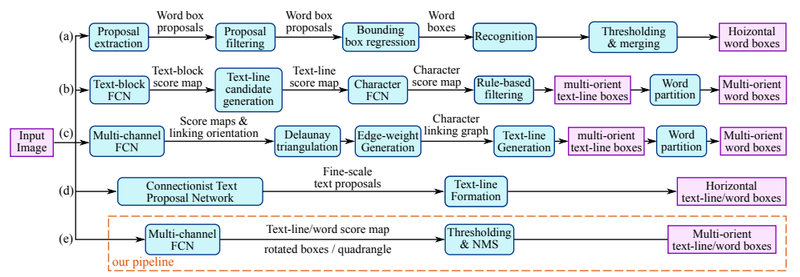

* Text의 BBox를 구하는 방법이 주류
* 여러 방향(Multi-oriented)의 텍스트 박스를 구하는 방식을 소개
* 전체길이가 짧고 간결하면서 정확한 Text detection 성능을 보임
* 단어 단위의 탐지와 글자 단위의 탐지 모두 활용
    > 1. 단어 단위는 Regression 기반의 Detection으로 Anchor를 활용
    > 2. 글자 단위의 방식은 글자 영역을 Segmentation

### Regression

[TextBoxes: A Fast Text Detector with a Single Deep Neural Network](https://arxiv.org/pdf/1611.06779.pdf)

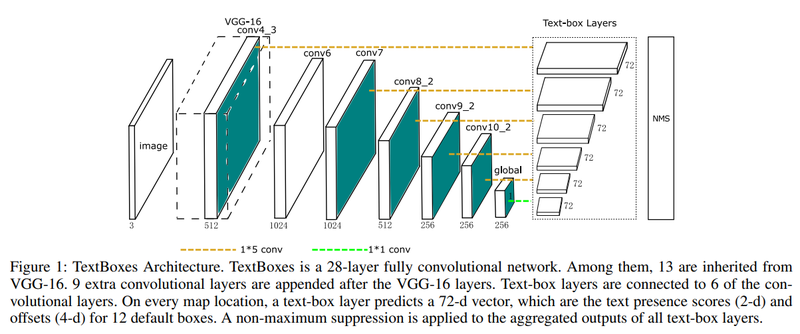

* SSD 네트워크를 활용하여 문자 영역을 탐지.
* 일반적으로 단어들은 종횡비(Aspect ratio)가 크기 때문에 네트워크에 약간의 변형을 줌
    > 3x3 과 같은 정사각 conv_filter가 아니라 1x1, 1x2, 1x3, 1x5, 1x7 과 같은 크기로 Anchor box를 만들고 촘촘하게 배열에 대응하도록 함
   

### Segmentation

[PixelLink: Detecting Scene Text via Instance Segmentation](https://arxiv.org/pdf/1801.01315.pdf)

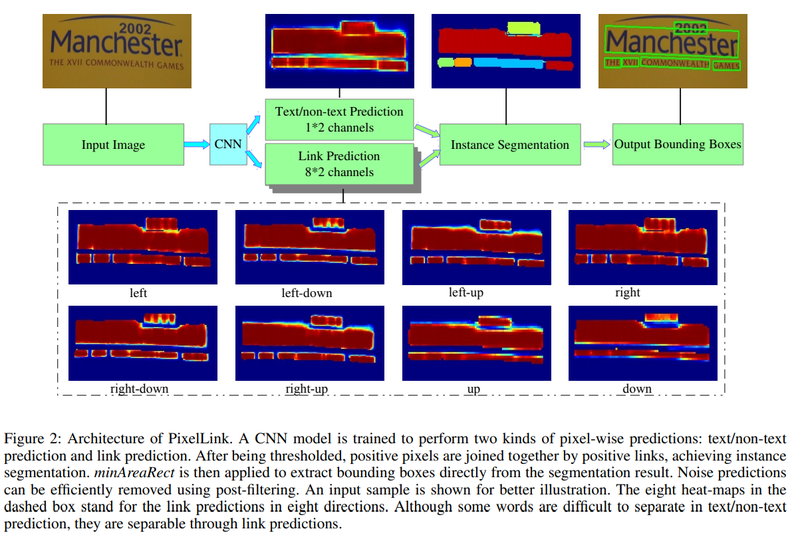

* 이미지내의 영역을 Class로 분리하는 방법을 차용
* 문자영역과 배경으로 분리
* 일반적으로 문자들은 매우 촘촘히 배열 되어 있기때문에 글자 영역으로 찾아낸 다음 이를 분리

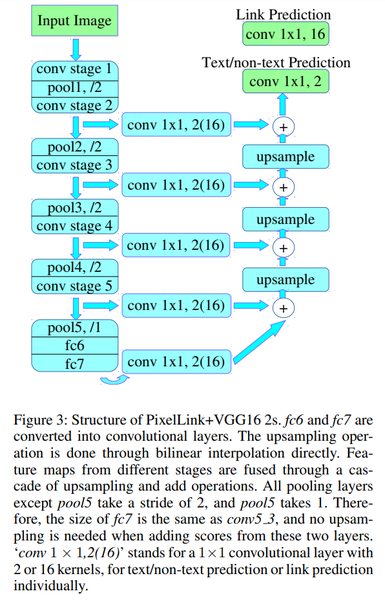

* 글자가 어느 방향으로 연결되는지를 같이 학습하여 Text 영역 간의 분리 및 연결

* 전체적인 구조는 U-Net과 유사하지만 output 으로 9가지 정보를 얻음
    1. Text 인지 아닌지 예측하는 2개의 커널
    2. 글자 Pixel 중심 인접 8픽셀에 대한 연결 여부

##  CRAFT

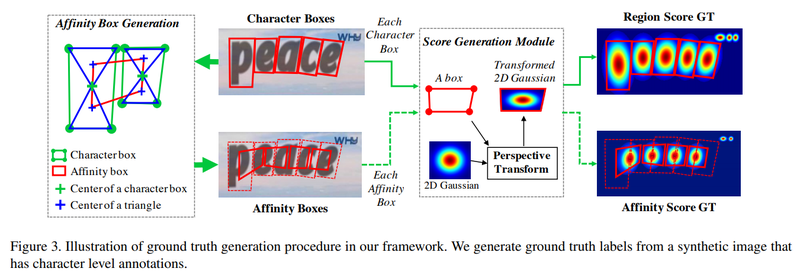

* CRAFT는 문자단위로 위치를 찾아낸 뒤, 이를 연결하는 방식
* 문자의 영역을 Boundary로 명확하게 구분하지 않고, 가우시안 분포의 원형 score map을 만들어서 배치
* 문자 단위 데이터셋은 적기 때문에, 단어 단위 정보만 있는 데이터 셋에 대해 단어의 영역에서 Inference를 한 후, 얻어진 문자 단위를 다시 학습에 사용

## Pyramid Mask Text Detector

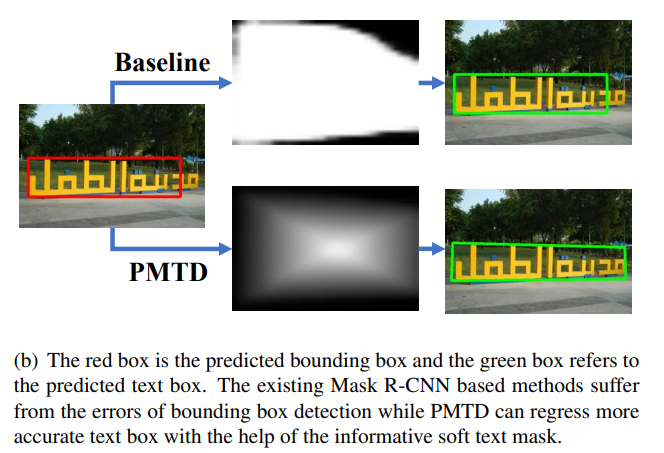

* PMTD는 Mask-RCNN의 구조를 활용하여 먼저 Text영역을 RPN으로 찾아냅니다.
* Box head에서 Regression과 Classification을 하고 Mask head에서 Instance Segmentation 합니다.

# OCR - Recognition 구현해보기

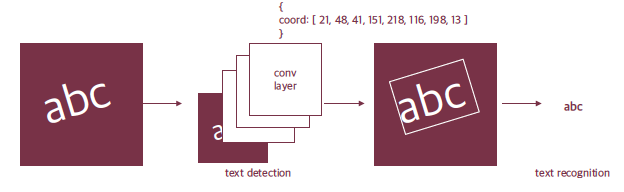

* OCR은 이미지 속에서 문자열을 Bounding box로 찾아내고 그 Bounding box 내에서 어떤 Text가 포함되는지 알 수 있는 시스템입니다.
* 이미지 속에서 문자 영역을 찾아내는 - **Text Detextion**
* 문자영역에서 문자를 인식하는 - **Recognition**
* 이 과정에서 Keras-OCR의 CRAFT를 이용하여 Segmentation 하며, Recognition은 직접 구현해보겠습니다.

Q1. keras-ocr에서도 recognition을 지원하는데요 이 모델은 어떤 구조를 썼을까요?
> Convolution layer와 RNN을 결합하고 CTC로 학습된 CRNN이 사용되었습니다.

Q2.. keras-ocr의 CRNN 기반 Recognition 모델과 위 논문에 소개된 Recognition에서 가장 높은 성능을 얻은 (저자들의) 모델은 어떤 점이 다를까요?
> 첫 번째로 입력 이미지 변환 단계에서는 모델의 앞에서 글자를 Thin plate spline Transformation을 해주는 TPS 모듈이 붙고
> 마지막 Text 출력 단계에서는 Bidirectional LSTM 뒤로 Attention decoder가 붙습니다.

OCR은 데이터의 비용이 큽니다. 이를 해결하기 위한 방법 중 하나로 컴퓨터로 대량의 문자 이미지 데이터를 만들어 내는 방법이 있습니다.
1. `MySynth`
2. `SynthText`

위 중에서 1번, MySynth 데이터를 사용하겠습니다.

## Recognition model

Text recognition 모델을 직접 만들어 보겠습니다.
|||
|:--:|:--:|
|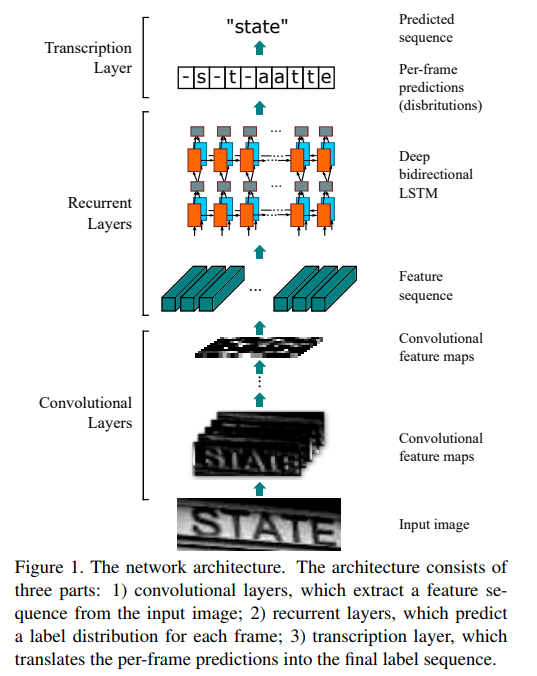|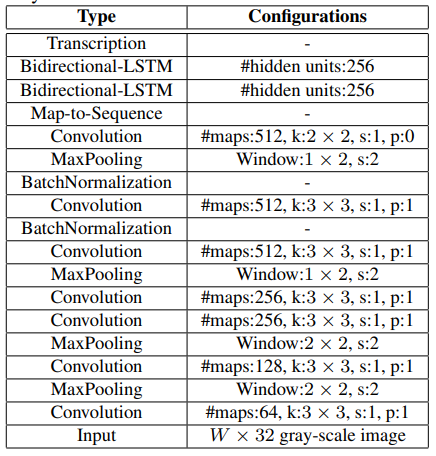|

* CRNN의 구조는 위 그림처럼 아래에서 위로 올라가는 순서입니다.
* 입력이미지를 Conv layer를 통해 Feature를 추출합니다.
* Recurrent Layer를 통해 추출된 Feature의 전체적인 Context를 파악하고 다양한 output 크기에 대응이 가능하도록 합니다.
* 마지막으로 Transcription layer(FCN) 단계에서 Step 마다 어떤 character의 확률이 높은지 예측합니다.

먼저 LMDB 를 이용합니다. LMDB는 Symas에서 만든 Lightning Memory-Mapped Database의 약자입니다. 오늘 우리가 다루게 될 데이터셋이 lmdb 포맷(mdb)의 파일로 이루어져 있습니다.

In [58]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 64
HOME_DIR = "D:/Dataset/dataset/data_lmdb_release/training/MJ/"

TRAIN_DATA_PATH = HOME_DIR+'MJ_train'
VALID_DATA_PATH = HOME_DIR+'MJ_valid'
TEST_DATA_PATH = HOME_DIR+'MJ_test'

print(TRAIN_DATA_PATH)

D:/Dataset/dataset/data_lmdb_release/training/MJ/MJ_train


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


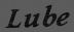

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


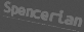

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


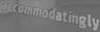

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


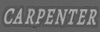

In [59]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [60]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [61]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self,
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100, 32),
                 max_text_len=22,
                 is_train=False,
                 character=''):

        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path,
                             max_readers=32,
                             readonly=True,
                             lock=False,
                             readahead=False,
                             meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]

    def __len__(self):
        return math.ceil(self.num_samples / self.batch_size /
                         self.divide_length)

    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size

            target_width = min(int(width * self.img_size[1] / height),
                               self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1, 0, 2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)

    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[idx * self.batch_size:(idx + 1) *
                                         self.batch_size]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size],
                               dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i, :width, :, :] = img
            labels[i, 0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

In [62]:
class LabelConverter(object):

    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)  # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [63]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


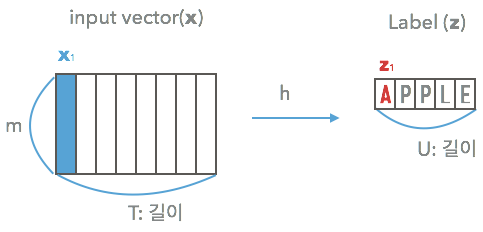

* 만약 모델이` AAAPPPPLLLLEE`을 출력했다고 합시다. 이때 추론 결과는`APLE`일지 `APPLE`일지 구분이 가능할까요? 이 경우에는 `APLE`로 결론을 내리게 될 것입니다.

* 그러므로 추론 결과가 `APPLE`이 되게 하려면 이미지의 라벨은 AP-PLE로 보정해 주어야 합니다. 그래서 모델이 `AAAPP-PPLLLEE`로 출력을 한다면 추론 결과는 `APPLE`이 되는 것입니다. 이런 이유로 이전 스텝에서 `LabelConverter.encode()` 메소드에 공백문자 처리로직을 포함했던 것입니다.

In [64]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

* y_true
    - tensor (samples, max_string_length) containing the truth labels.
    - 실제 라벨 LUBE. 텍스트 라벨 그대로가 아니라, 각 글자를 One-hot 인코딩한 형태로서, max_string_length 값은 모델에서 22로 지정할 예정
* y_pred
    - tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.
    - 우리가 만들 RCNN 모델의 출력 결과. 길이는 4가 아니라 우리가 만들 RNN의 최종 출력 길이로서 24가 될 예정
* input_length tensor
    - (samples, 1) containing the sequence length for each batch item in y_pred.
    - 모델 입력 길이 T로서, 이 경우에는 텍스트의 width인 74
 * label_length tensor - 
     - (samples, 1) containing the sequence length for each batch item in y_true.
     - 라벨의 실제 정답 길이 U로서, 이 경우에는 4
     
* Returns
    - Tensor with shape (samples,1) containing the CTC loss of each element.

In [65]:
print(TARGET_CHARACTERS)
print(len(TARGET_CHARACTERS))

ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789
36


In [66]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    """
    input_shape
    character
    ---
    input
    1. image_input
    2. labels
    3. input_length
    4. label_length
    
    output
    1. ctc_batch_cost
    ---
    """
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    # CNN
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    # RNN
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    #########################
    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

In [67]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH,
                              label_converter,
                              batch_size=BATCH_SIZE,
                              character=TARGET_CHARACTERS,
                              is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH,
                            label_converter,
                            batch_size=BATCH_SIZE,
                            character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer, metrics="acc")

In [68]:
model.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 32, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 100, 32, 64)  1792        ['input_image[0][0]']            
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 50, 16, 64)   0           ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 50, 16, 128)  73856       ['max_pooling2d[0][0]']   

In [21]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
checkpoint_path = './model_checkpoint.hdf5'
model.load_weights(checkpoint_path)

ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    verbose=0,
    mode='min',
    restore_best_weights=True,
)
history = model.fit(train_set,
                    steps_per_epoch=len(train_set),
                    epochs=5,
                    validation_data=val_set,
                    validation_steps=len(val_set),
                    callbacks=[ckp, earlystop])

Epoch 1/5
1129/1129 [==============================] - ETA: 0s - loss: 2.5398 - acc: 0.5556
Epoch 1: val_loss improved from inf to 4.09896, saving model to .\model_checkpoint.hdf5
1129/1129 [==============================] - 101s 89ms/step - loss: 2.5398 - acc: 0.5556 - val_loss: 4.0990 - val_acc: 0.4666
Epoch 2/5
1129/1129 [==============================] - ETA: 0s - loss: 2.0415 - acc: 0.6200
Epoch 2: val_loss did not improve from 4.09896
1129/1129 [==============================] - 101s 89ms/step - loss: 2.0415 - acc: 0.6200 - val_loss: 4.2204 - val_acc: 0.5084
Epoch 3/5
1129/1129 [==============================] - ETA: 0s - loss: 1.6498 - acc: 0.6700
Epoch 3: val_loss did not improve from 4.09896
1129/1129 [==============================] - 100s 89ms/step - loss: 1.6498 - acc: 0.6700 - val_loss: 4.2030 - val_acc: 0.5109
Epoch 4/5
1129/1129 [==============================] - ETA: 0s - loss: 1.3181 - acc: 0.7179
Epoch 4: val_loss did not improve from 4.09896
1129/1129 [==============

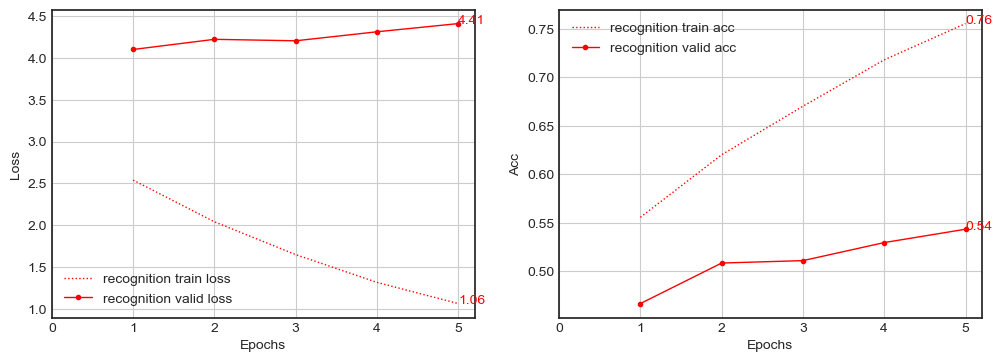

In [28]:
from Myfunc import show_lcurve

# 이전의 스텝은 shutdown 이슈로 삭제됨..
show_lcurve(hists=[history],titles=["recognition"])

In [22]:
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)
# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다

# input : input_image, output: label
# 구조의 Model로 재 정의
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

1/1 [==============================] - 2s 2s/step
Result: 	 SLINKING9999999999999999


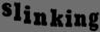

1/1 [==============================] - 0s 25ms/step
Result: 	 FIN999999999999999999999


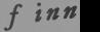

1/1 [==============================] - 0s 26ms/step
Result: 	 ALEPPO99999999999999999


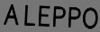

1/1 [==============================] - 0s 25ms/step
Result: 	 UPSIDES99999999999999999


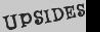

1/1 [==============================] - 0s 29ms/step
Result: 	 PWANDE999999999999999999


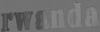

1/1 [==============================] - 0s 28ms/step
Result: 	 SINUOSITY999999999999999


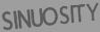

1/1 [==============================] - 0s 29ms/step
Result: 	 NATHANS99999999999999999


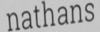

1/1 [==============================] - 0s 29ms/step
Result: 	 ANOREATIE999999999999999


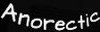

1/1 [==============================] - 0s 31ms/step
Result: 	 HALLED99999999999999999


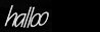

1/1 [==============================] - 0s 28ms/step
Result: 	 ANNUITIES99999999999999


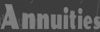

In [23]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

# OCR - Keras_OCR - RPN

In [81]:
import tensorflow as tf
import numpy as np
import cv2
import keras_ocr
import matplotlib.pyplot as plt
from PIL import Image
import os

from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = './sample.jpg'

detector = Detector()

Looking for C:\Users\rh987\.keras-ocr\craft_mlt_25k.h5


In [80]:
def detect_text(img_path, output_path):
    
    def createDirectory(output_path):
        try:
            if not os.path.exists(output_path):
                os.makedirs(output_path)
        except OSError:
            print("Error: Failed to create the directory.")

    # TODO
    images = keras_ocr.tools.read(img_path)
    prediction_groups = detector.detect([images])

    img_pil = Image.open(img_path)

    cropped_imgs = []
    for idx1, prediction_group in enumerate(prediction_groups):
        for idx2, text_result in enumerate(prediction_group):
            x_min = text_result[:,0].min() - 5
            x_max = text_result[:,0].max() + 5
            y_min = text_result[:,1].min() - 5
            y_max = text_result[:,1].max() + 5
            word_box = [x_min, y_min, x_max, y_max]
            image_name = os.path.join(output_path,f"sample_{idx1:02d}_{idx2:02d}.jpg")
            img_pil.crop(word_box).save(image_name)
            
    return output_path

output_path = "./sample_images/cropped/"
detect_text(SAMPLE_IMG_PATH,output_path)

1/1 [==============================] - 0s 32ms/step


'./sample_images/cropped/'

In [85]:
SAMPLE_DATA_PATH = detect_text(SAMPLE_IMG_PATH,output_path)
sample_set = MJDatasetSequence(SAMPLE_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)
# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다

# input : input_image, output: label
# 구조의 Model로 재 정의
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

1/1 [==============================] - 0s 28ms/step


Error: ./sample_images/cropped/: No such file or directory

1/1 [==============================] - 2s 2s/step
Result: 	 SLINKING9999999999999999


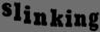

1/1 [==============================] - 0s 24ms/step
Result: 	 FIN999999999999999999999


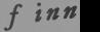

In [84]:
def check_inference(model, images_path, index = 5):
    for idx, i in enumerate(images_path):
        if idx>=index:
            break
        
        Image.
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, sample_set, index=2)